In [1]:
import os
import os.path
import shutil
import math
import subprocess
import numpy
import pickle
import pandas as pd
import matplotlib.pyplot as plt


from amuse.units import units, constants, nbody_system
from amuse.units.core import enumeration_unit
from amuse.units.generic_unit_converter import ConvertBetweenGenericAndSiUnits
from amuse.datamodel import Particles, Particle, ParticlesSuperset
from amuse.io import write_set_to_file, read_set_from_file
from amuse.support.exceptions import AmuseException

from amuse.datamodel.particle_attributes import total_angular_momentum, kinetic_energy
from amuse.ext.orbital_elements import orbital_elements_from_binary, orbital_period_to_semimajor_axis, get_orbital_elements_from_binaries
from amuse.ext.star_to_sph import convert_stellar_model_to_SPH, StellarModelInSPH
from amuse.ext.sink import new_sink_particles
from amuse.ext.star_to_sph import convert_stellar_model_to_SPH, StellarModelInSPH
from amuse.couple.bridge import Bridge, CalculateFieldForParticles

from amuse.community.evtwin.interface import EVtwin
from amuse.community.mesa.interface import MESA # original
from amuse.community.gadget2.interface import Gadget2
from amuse.community.twobody.twobody import TwoBody
from amuse.community.huayno.interface import Huayno

import matplotlib
#matplotlib.use("Agg")
from matplotlib import pyplot
from amuse.plot import scatter, xlabel, ylabel, plot,loglog,semilogx,semilogy, sph_particles_plot
from amuse.plot import pynbody_column_density_plot, HAS_PYNBODY

In [2]:
def dynamical_time_scale(m, r, G=constants.G):
    return numpy.sqrt(r**3/(2*constants.G*m))

def Kelvin_Helmholtz_timescale(m, r, L):
    return constants.G*m**2/(r*L)

def nuclear_time_scale(l, L):
    return 7e-4 * m * constants.c**2/L

def relaxation_time_scale(N, M, R, G=constants.G):
    return 0.138*N/numpy.log(0.4*N) * dynamical_time_scale(M, R, G=constants.G)

def semimajor_axis(orb_per,M_tot):
    orb_per = orb_per | units.day
    M_tot = M_tot | units.MSun
    return (((constants.G * M_tot*orb_per**2)/(4 * numpy.pi**2))**(1/3)).as_quantity_in(units.AU)
    

In [3]:
def new_working_directory():
    i = 0
    current_directory = os.getcwd()
    while os.path.exists(os.path.join(current_directory, "run_{0:=03}".format(i))):
        i += 1
    new_directory = os.path.join(current_directory, "run_{0:=03}".format(i))
    os.mkdir(new_directory)
    print("Created new directory for output:", new_directory)
    os.mkdir(os.path.join(new_directory, "plots"))
    os.mkdir(os.path.join(new_directory, "snapshots"))
    shutil.copy(__file__, new_directory)
    if not os.path.exists(os.path.join(current_directory, "giant_models")):
        os.mkdir(os.path.join(current_directory, "giant_models"))
    os.chdir(new_directory)

def get_relative_velocity(total_mass, semimajor_axis, ecc):
    '''
    calculates and returns the relative velocity of a star as ( GM *((1+e)/(1-e))/alpha )^0.5
    '''
    return (constants.G * total_mass * ((1.0 + ecc)/(1.0 - ecc)) / semimajor_axis).sqrt()

def set_up_inner_binary():
    '''
    Sets the orbital parameters of the inner binary, moves the binary
    to the center of mass of the three-body system:

    particles.position -= particles.center_of_mass()
    particles.velocity -= particles.center_of_mass_velocity()

    and returns the binary
    '''
    #semimajor_axis = 0.133256133158 | units.AU  # 0.048273275517640366 
    orbital_period = 1.10 | units.day
    eccentricity = 0
    masses = [6.5, 5.9] | units.MSun #  3.2,3.1
    semimajor_axis = orbital_period_to_semimajor_axis(orbital_period, masses[0], masses[1])
    
    #orbital_period = (4 * numpy.pi**2 * semimajor_axis**3 / 
    #    (constants.G * masses.sum())).sqrt().as_quantity_in(units.day)
    
    print("   Initializing inner binary")
    #print("   Orbital period inner binary:", orbital_period)
    stars =  Particles(2)
    stars.mass = masses
    stars.position = [0.0, 0.0, 0.0] | units.AU
    stars.velocity = [0.0, 0.0, 0.0] | units.km / units.s
    stars[0].x = semimajor_axis
    stars[0].vy = get_relative_velocity(stars.total_mass(), semimajor_axis, eccentricity)
    stars.move_to_center()                     # more info in /src/amuse/datamodel/particle_attributes.py
    print('Inner binary orbital seperation in {:.2f} au'.format( \
        (stars[0].position - stars[1].position).length().value_in(units.au)))
    return stars

def set_up_outer_star(inner_binary_mass):
    '''
    Input: inner binary combined mass 
    
    Sets the orbital parameters of the tertiary, takes the inner binary mass to set 
    the relative velocity of the tertiary with respect to the inner binary (the tertiary
    gravitationaly 'sees' the inner binary as a star with mass = inner_binary_mass) 
    and returns the tertiary
    '''
    #semimajor_axis = 1.22726535008 | units.AU  #  ,0.8274288819130811
    orbital_period = 52.04 | units.day
    eccentricity = 0.15     # 0.3
    inclination = math.radians(16.8)  #   9.0
    
    print("   Initializing outer star")
    giant = Particle()
    giant.mass = 16.0 | units.MSun # 5.5
    semimajor_axis = orbital_period_to_semimajor_axis(orbital_period, giant.mass, inner_binary_mass)
    giant.position = semimajor_axis * ([math.cos(inclination), 0, math.sin(inclination)] | units.none)
    giant.velocity = get_relative_velocity(giant.mass + inner_binary_mass, 
        semimajor_axis, eccentricity) * ([0, 1, 0] | units.none)
    return giant

def set_up_initial_conditions():
    '''
    Sets up the initial conditions for the triple system by adding the tertiary to the system.
    'stars' variable contains now the three stars but 'view_on_giant' is just the tertiary.
    It also moves the system's coordinates in to the center of mass of the triple and returns the triple and
    the tertiary alone. The local 'stars' variable is the 'triple' variable in the main code.
    '''
    stars = set_up_inner_binary()
    giant = set_up_outer_star(stars.total_mass())
    view_on_giant = stars.add_particle(giant) # This is just the tertiary and not the whole system
    stars.move_to_center()
    return stars, view_on_giant

def triple_set_up_info(triple, view_on_giant):
    a_bin = ((triple-view_on_giant).center_of_mass() - triple.center_of_mass()).length().value_in(units.au)
    print("\nBinary system semi-major axis is {:.2f} AU".format(a_bin)) 
    a_giant = triple[2].position.length().value_in(units.AU)      
    print("Giant's semi-major is axis {:0.2f} AU".format(a_giant))
    dist_giant = (view_on_giant.position - (triple-view_on_giant).center_of_mass()).length().value_in(units.au)
    print("Giant's distance from binar's COM is {:.2f} RSun".format(dist_giant))

def estimate_roche_radius(triple, view_on_giant):
    '''
    Estimates and returns the Roche radius of the tertiary. In the calculation of the semi-major axis of the 
    tertiary the inclination of the tertiary's orbit is also taken into account by the position
    of the tertiary in the 3D space, but the the inner binay is 'seen' as a mass point by the
    tertiary. Furthermore, it is assumed that the tertiary's orbit is circular in the calculation
    of the Roche radius. 
    
    --> At this point a correction can be made to include the eccenticity of the tertiary, in the calculation
    of the Roche lobe 
    '''
    # 'mass ratio' of giant to inner binary
    q = (view_on_giant.mass / (triple-view_on_giant).total_mass())
    # Assume ~ circular orbit:
    a = (view_on_giant.position - (triple-view_on_giant).center_of_mass()).length()
    q13 = q**(1./3.)
    q23 = q13**2
    return (a*(0.49*q23/(0.6*q23+math.log(1+q13)))).as_quantity_in(units.RSun)


def evolve_stars(triple, view_on_giant, stellar_code,radius_factor):
    se_giant = stellar_code.particles.add_particle(view_on_giant)
    #print(stellar_code.parameters)
    
    initial_mass = stellar_code.particles.mass
    initial_radius = stellar_code.particles.radius
    initial_luminosity = stellar_code.particles.luminosity
    
    stop_radius = radius_factor * estimate_roche_radius(triple, view_on_giant)
    print('Roche Lobe radius of the tertiary ={:.2f} au'.format(stop_radius.value_in(units.au)))
    #stellar_code_options = dict(redirection='file', redirect_file='stellar_evolution_code_out.log')
    
    columns_names = ['star_age', 'star_mass', 'log_R', 'log_L', 'log_Teff', 'wind(MSun/yr)', 'log_cntr_Rho', 'log_cntr_T', 'stellar type']
    mesa_output = pd.DataFrame(columns = columns_names)
    
    
    while se_giant.radius < stop_radius.in_(units.RSun):
        stellar_code.evolve_model(keep_synchronous = False)#, **stellar_code_options)
        print(se_giant.mass.in_(units.MSun), se_giant.wind.in_(units.MSun / units.yr), se_giant.age.in_(units.Myr),
             se_giant.radius.in_(units.RSun), se_giant.stellar_type)
        
        mesa_output = pd.concat([mesa_output,pd.DataFrame({'star_age':se_giant.age.value_in(units.Myr), 'star_mass': se_giant.mass.value_in(units.MSun),
                                          'log_R': numpy.log10(se_giant.radius.value_in(units.RSun)),'log_L': numpy.log10(se_giant.luminosity.value_in(units.LSun)),
                                          'log_Teff': numpy.log10(se_giant.temperature.value_in(units.K)),'wind(MSun/yr)': se_giant.wind.value_in(units.MSun / units.yr),
                                          'log_cntr_Rho': numpy.log10(se_giant.central_density.value_in(units.g / units.cm**3)),'log_cntr_T': numpy.log10(se_giant.central_temperature.value_in(units.K)),
                                          'stellar type':se_giant.stellar_type},index=[0])], ignore_index=True, sort=False)

    print(stellar_code.parameters)    
    print('\n M(t=0)=', initial_mass, \
          '\n R(t=0)=', initial_radius, \
          '\n L(t=0)=', initial_luminosity, \
          
          
          '\n at t=', se_giant.age.in_(units.Myr), \
          '\n M(t) =', stellar_code.particles.mass.in_(units.MSun), \
          '\n R(t) =', stellar_code.particles.radius.in_(units.RSun), \
          '\n L(t) =', stellar_code.particles.luminosity.in_(units.LSun), \
          '\n Stellar type =', stellar_code.particles.stellar_type, \
         )
    #mesa_output.to_csv('amuse_mesa_runs/stellar_evolution_code_output_Fov_00275', sep='\t', index=False)
  
    se_binary = stellar_code.particles.add_particles(triple - view_on_giant)
    print(stellar_code.particles.time_step)
    for particle in se_binary:
        particle.evolve_for(se_giant.age)
        print(particle.age.in_(units.Myr),particle.time_step)
    return stellar_code.particles, stellar_code, mesa_output

def energy_evolution_plot(time, kinetic, potential, thermal, figname = "energy_evolution.png"):
    time.prepend(0.0 | units.day)
    pyplot.figure(figsize = (5, 5))
    plot(time, kinetic, label='Kinetic En.')
    plot(time, potential, label='Potential En.')
    plot(time, thermal, label='Thermal En')
    plot(time, kinetic + potential + thermal, label='Total En.')
    xlabel('Time')
    ylabel('Energy')
    pyplot.legend(prop={'size':"x-small"}, loc=4)
    pyplot.savefig(figname)
    pyplot.close()

def convert_giant_to_sph(view_on_se_giant, number_of_sph_particles): #pickle_file
    '''
    Converting the 1D stellar evolution model to a gas particle distribution       # more info /src/amuse/ext/star_to_sph.py

    Converts the tertiary star to a collection of SPH particles based on the output of the stellar evolution code.
    Thus, the collection of particles is characterized by the temperature, density etc profiles that characterize the evolved
    tertiary at the moment when its radius is equal with its Roche radius. It returns the the collection of the particles.
    '''
    giant_in_sph = convert_stellar_model_to_SPH(
        view_on_se_giant,                                                              # Star particle to be converted to an SPH model
        number_of_sph_particles,                                                       
        with_core_particle = True,                                                     # Model the core as a heavy, non-sph particle
        target_core_mass  = 7.0 | units.MSun,                  # 1.4 | units.MSun      # If (with_core_particle): target mass for the non-sph particle (in paper M = 2, ?)
        do_store_composition = False                                                   # If set, store the local chemical composition on each particle 
    )
    return giant_in_sph


def relax_in_isolation(giant_in_sph, sph_code, output_base_name, mult_factor):
    '''
    Calculates the total mass of the star as the mass of the SPH particles representing the outer layers plus
    the mass of a non-SPH particle representing the core. Calculates the total radius of the star as the position
    of the most distant SPH particle. Calculates the dynamical evolution timescale which is used to calculate
    the relaxation time scale of the system. The latter represent the time scale on which the global characteristics
    (bulk system parameters and stellar orbital elements) of the system change.
    

     --> not sure why t_end = 10*t_dyn, if t_end is the t_relax then the constant 10 seems small based on the
     t_relax = 0.138*(N/lnγN)*t_dyn, where in this code N=50000

    '''
    total_mass = giant_in_sph.gas_particles.total_mass() + giant_in_sph.core_particle.mass  
    total_radius = max(giant_in_sph.gas_particles.position.lengths_squared()).sqrt()
    #print(total_mass.in_(units.MSun),total_radius.in_(units.RSun))
    dynamical_timescale = (total_radius**3 / (2 * constants.G * total_mass)).sqrt().as_quantity_in(units.day)
    t_end = (mult_factor * dynamical_timescale).as_quantity_in(units.day) 
    #t_end = 0.138*(N/numpy.log(0.4*N)) * dynamical_time_scale
    n_steps = 100
    hydro_code_options = dict(number_of_workers=3, redirection='file', redirect_file='hydrodynamics_code_relax_out.log')

    unit_converter = ConvertBetweenGenericAndSiUnits(total_radius, total_mass, t_end)           # more info in /src/amuse/units/generic_unit_converter.py
    hydrodynamics = sph_code(unit_converter, **hydro_code_options)
    hydrodynamics.parameters.epsilon_squared = giant_in_sph.core_radius**2                     # Softening removes the singularity in the inverse-square force
    hydrodynamics.parameters.max_size_timestep = t_end
    hydrodynamics.parameters.time_max = 1.1 * t_end
    hydrodynamics.parameters.time_limit_cpu = 7.0 | units.day
    hydrodynamics.gas_particles.add_particles(giant_in_sph.gas_particles)
    hydrodynamics.dm_particles.add_particle(giant_in_sph.core_particle)
    
    potential_energies = hydrodynamics.potential_energy.as_vector_with_length(1).as_quantity_in(units.erg)
    kinetic_energies = hydrodynamics.kinetic_energy.as_vector_with_length(1).as_quantity_in(units.erg)
    thermal_energies = hydrodynamics.thermal_energy.as_vector_with_length(1).as_quantity_in(units.erg)
    
    print("Relaxing for {:.2f} ({:.0f} * dynamical timescale)".format(t_end.value_in(units.day),mult_factor))
    times = (t_end * list(range(1, n_steps+1)) / n_steps).as_quantity_in(units.day)
    for i_step, time in enumerate(times):
        hydrodynamics.evolve_model(time)
        print("   Relaxed for:", time)
        potential_energies.append(hydrodynamics.potential_energy)
        kinetic_energies.append(hydrodynamics.kinetic_energy)
        thermal_energies.append(hydrodynamics.thermal_energy)
        
    
    hydrodynamics.gas_particles.copy_values_of_attributes_to(
        ['mass', 'x','y','z', 'vx','vy','vz', 'u', 'h_smooth'], 
        giant_in_sph.gas_particles)
    giant_in_sph.core_particle.position = hydrodynamics.dm_particles[0].position
    giant_in_sph.core_particle.velocity = hydrodynamics.dm_particles[0].velocity
    hydrodynamics.stop()
    
    
    snapshotfile_path = 'data/Mc_7/'
    plt.figure(figsize=(5,5))
    plt.scatter(giant_model.gas_particles.x.value_in(units.RSun) ,giant_model.gas_particles.y.value_in(units.RSun))
    plt.scatter(giant_model.core_particle.x.value_in(units.RSun) ,giant_model.core_particle.y.value_in(units.RSun),c='red', label=r'M$_{core}$ = 3 M$_{\odot}$')
    plt.savefig(snapshotfile_path + output_base_name, format='png')
    
    
    snapshotfile = snapshotfile_path+output_base_name + "_gas.amuse"
    write_set_to_file(giant_in_sph.gas_particles, snapshotfile, format='amuse')
    shutil.copy(snapshotfile, os.path.join("..", "giant_models"))
    
    snapshotfile = snapshotfile_path+output_base_name + "_core.amuse"
    # temporarily store core_radius on the core particle
    giant_in_sph.core_particle.radius = giant_in_sph.core_radius
    write_set_to_file(giant_in_sph.core_particle.as_set(), snapshotfile, format='amuse')
    #giant_in_sph.core_particle.radius = 0.0 | units.m
    shutil.copy(snapshotfile, os.path.join("..", "giant_models"))
    
    energy_evolution_plot(times, kinetic_energies, potential_energies, thermal_energies, 
        figname = snapshotfile_path+output_base_name + "_energy_evolution.png")

In [4]:
def amuse_mesa_profiles(tertiary):
    """
    Return all the profiles of the tertiary calculated by the stellar evolution code
    """
    giant_num_zones = numpy.arange(1,tertiary.get_number_of_zones()+1)
    giant_dens_profile = tertiary.get_density_profile(number_of_zones = tertiary.get_number_of_zones())
    giant_temp_profile = tertiary.get_temperature_profile(number_of_zones = tertiary.get_number_of_zones())
    giant_rad_profile = tertiary.get_radius_profile(number_of_zones = tertiary.get_number_of_zones())
    giant_mass_profile = tertiary.get_mass_profile(number_of_zones = tertiary.get_number_of_zones())
    giant_lum_profile = tertiary.get_luminosity_profile(number_of_zones = tertiary.get_number_of_zones())
    giant_mu_profile = tertiary.get_mu_profile(number_of_zones = tertiary.get_number_of_zones())
    giant_chemical_abundance_profile = tertiary.get_chemical_abundance_profiles(number_of_zones = tertiary.get_number_of_zones())
    return giant_num_zones, giant_dens_profile, giant_temp_profile, giant_rad_profile, giant_mass_profile, giant_lum_profile, giant_mu_profile, giant_chemical_abundance_profile

class EnclosedMassInterpolator(object):
    """
    Interpolator used in 'get_enclosed_mass_from_tabulated' and 'get_radius_for_enclosed_mass'.
    These two functions are required for 'new_spherical_particle_distribution'.
    """
    def __init__(self, radii = None, densities = None, core_radius = None):
        self.initialized = False
        self.four_thirds_pi = numpy.pi * 4.0/3.0
        if (radii and densities):
            self.initialize(radii, densities, core_radius = core_radius)
    
    def initialize(self, radii, densities, core_radius = None):
        self.sort_density_and_radius(densities*1.0, radii*1.0, core_radius = core_radius)
        self.calculate_enclosed_mass_table()
        self.initialized = True
        
    def sort_density_and_radius(self, densities, radii, core_radius = None):
        self.radii, self.densities = radii.sorted_with(densities)
        self.radii.prepend(core_radius or 0 | units.m)
    
    def calculate_enclosed_mass_table(self):
        self.radii_cubed = self.radii**3
        self.enclosed_mass = [0.0] | units.kg
        for rho_shell, r3_in, r3_out in zip(self.densities, self.radii_cubed, self.radii_cubed[1:]):
            self.enclosed_mass.append(self.enclosed_mass[-1] + rho_shell * (r3_out - r3_in))
        self.enclosed_mass = self.four_thirds_pi * self.enclosed_mass
        
def intersting_subset(part_collect,num):
    return print(part_collect.as_set().get_intersecting_subset_in(part_collect)[num])

def den_profile(gas,core,mesa_num_of_zones,shell_edges,shell_cents):
    
    # gonna store here the mass of each shell
    shells_mass = numpy.zeros(mesa_num_of_zones) #one less because the core will be added as a compact shell later
    shells_volume = shell_edges**3
    shells_dr = shells_volume[1:]-shells_volume[:-1]
    # finds in which shell each particle belongs to. Need to make this faster
    for dist,mass in zip(gas.dist_from_cm.value_in(units.RSun),gas.mass.value_in(units.kg)):
        index = numpy.where((shell_edges[:-1] < dist) & (shell_edges[1:] >= dist))
        if index[0].size >0:
            shells_mass[index[0][0]] += mass
    
    core.density = (3*core.mass).in_(units.kg) /(4*numpy.pi*core.radius**3).in_(units.RSun**3)               
    density_profile = (3*shells_mass)/(4*numpy.pi*shells_dr)
    density_profile = numpy.insert(density_profile,0,(core.density.value_in(units.kg / units.RSun**3)))

    # position of the core particle
    shell_cents = numpy.insert(shell_cents,0,0.0)
    return (shell_cents | units.RSun), (density_profile | units.kg / units.RSun**3).in_(units.g / units.cm**3) #.value_in(units.RSun)
    

def tertiary_profiles(gas,core,not_array=False):
    '''
    combines the gas particles with the core particle and moves the system to the center of mass, i.e. center
    of the star. Then seperates the star in `mesa_num_of_zones` spherical shells to calculate the different
    profiles
    '''
    third_star = gas.copy()
    third_star.add_particle(core)
    third_star.move_to_center()
    third_star.dist_from_cm = third_star.position.lengths().in_(units.RSun)
    
    #max_rad = (71.8 | units.RSun).value_in(units.cm)
    max_rad = third_star.position.lengths().max().value_in(units.RSun)
    # shells of 0.65 RSun width
    mesa_num_of_zones = int(max_rad//0.65)
    
    if not_array == True:
        shell_edges = numpy.linspace(core.radius.value_in(units.RSun), max_rad, mesa_num_of_zones+1)
    else:
        shell_edges = numpy.linspace(core.radius.value_in(units.RSun)[0], max_rad, mesa_num_of_zones+1)
    shell_cents = numpy.convolve(shell_edges,numpy.array([0.5, 0.5]), mode= 'valid')
    
    # return the gas and the core
    return den_profile(third_star[:-1],third_star[-1],mesa_num_of_zones,shell_edges,shell_cents)

def plot_giant(gas,core):
    plt.figure(figsize=(5,5))
    plt.scatter(gas.x.value_in(units.RSun) ,gas.y.value_in(units.RSun))
    #plt.scatter(binary_particles.x.value_in(units.RSun) ,binary_particles.y.value_in(units.RSun), c='black')
    plt.scatter(core.x.value_in(units.RSun) ,core.y.value_in(units.RSun),c='red')
    plt.xlabel(r'R $(R_{\odot})$')
    plt.ylabel(r'R $(R_{\odot})$')
    #plt.xlim(-1,1)
    #plt.ylim(-1,1)
    plt.show()

def enc_mass(enc_mass_prof, rad_prof,perce):
    ind = numpy.where(enc_mass_prof>=perce)[0][0]
    return rad_prof[ind].value_in(units.RSun)
    
def plt_dens_profiles(se_rad,se_dens,hyd_rad,hyd_dens,star_enc_mass,relax_time):
    fig, ax1 = plt.subplots(dpi=200)
    ax1.plot(se_rad.value_in(units.RSun), se_dens.value_in(units.g / units.cm**3), label='MESA') 
    ax1.scatter(hyd_rad.value_in(units.RSun), hyd_dens.value_in(units.g / units.cm**3), marker='.', label='Gadget2', c='blue')
    X = enc_mass(star_enc_mass, se_rad, 0.999)
    ax1.axvspan(0, X, alpha=0.2, color='blue', label = r'$M_{encl}=99.9\% M_{\star}$')
    ax1.scatter(hyd_rad[0].value_in(units.RSun),hyd_dens[0].value_in(units.g / units.cm**3), color='red', label=r'M$_{core}$ = 7 M$_{\odot}$')
    ax1.set_xlabel(r'$R \; (R_{\odot})$')
    ax1.set_ylabel(r'$\rho \; (g/cm^3)$')
    ax1.legend()
    plt.yscale('log')
    plt.xlim(0,80)

    
    #plt.savefig('dens_plot_7Mc_25e4part_{:.0f}rel.png'.format(relax_time))
    plt.show()
    
def plot_spec_kin_energy(gas):
    plt.figure(figsize=(5,5))
    plt.scatter(gas.position.lengths().value_in(units.RSun), \
                gas.specific_kinetic_energy().value_in(units.m**2 / units.s**2))

    plt.xlabel(r'R $(R_{\odot})$')
    plt.ylabel(r'specific kinetic energy $(m^2 s^{-2})$')
    plt.show()
    
def plot_spec_kin_energy_map(gas):
    plt.figure(figsize=(5,5))
    cm = plt.cm.get_cmap('RdYlBu')
    z = gas.specific_kinetic_energy().value_in(units.m**2 / units.s**2)
    min_z = gas.specific_kinetic_energy().value_in(units.m**2 / units.s**2).min()
    max_z = gas.specific_kinetic_energy().value_in(units.m**2 / units.s**2).max()
    sc = plt.scatter(gas.x.value_in(units.RSun),gas.y.value_in(units.RSun), c=z, vmin=min_z, vmax=max_z, s=35, cmap=cm)
    plt.colorbar(sc)
    plt.xlabel(r'x $(R_{\odot})$')
    plt.ylabel(r'y $(R_{\odot})$')
    plt.show()

# Main

In [5]:
number_of_sph_particles = 250000
t_end = 100.0 | units.day
n_steps = 200



triple, view_on_giant = set_up_initial_conditions()
radius_factor= 1.05
stop_radius = radius_factor * estimate_roche_radius(triple, view_on_giant)

print("Tertiary's Roche lobe radius is {:.2f} RSun or {:.2f} AU".format(stop_radius.value_in(units.RSun), \
                                                                     stop_radius.value_in(units.au)))

triple_set_up_info(triple, view_on_giant)

   Initializing inner binary
Inner binary orbital seperation in 0.05 au
   Initializing outer star
Tertiary's Roche lobe radius is 75.41 RSun or 0.35 AU

Binary system semi-major axis is 0.47 AU
Giant's semi-major is axis 0.36 AU
Giant's distance from binar's COM is 0.83 RSun


In [6]:
# Stop stellar evolution when giant's radius is (radius_factor * Roche lobe radius)
mult_factor = [10.0]

for dummy_var,mult_f in enumerate(mult_factor):
    se_code = MESA(version='2208')
    sph_code = Gadget2
    print("Relaxing giant with", sph_code.__name__)
    se_stars, se_code_instance , stellar_evolution_output = evolve_stars(triple, view_on_giant, se_code, radius_factor)
    view_on_se_giant = view_on_giant.as_set().get_intersecting_subset_in(se_stars)[0]
    
    ## Giant's profile at ROLF
    if dummy_var == (len(mult_factor)-1):
        giant_num_zones, giant_dens_profile, giant_temp_profile, giant_rad_profile, \
        giant_mass_profile,giant_lum_profile,giant_mu_profile,giant_chemical_abundance_profile \
        =amuse_mesa_profiles(se_stars[0])

        interpolator = EnclosedMassInterpolator()
        interpolator.initialize(giant_rad_profile, giant_dens_profile)
        enc_mass_calc =(interpolator.enclosed_mass.value_in(units.MSun)/se_stars[0].mass.value_in(units.MSun))[1:]
    
    giant_model = convert_giant_to_sph(view_on_se_giant, number_of_sph_particles)
    se_code_instance.stop()  
    
    relaxed_giant_output_base_name = "relaxed_giant_" + str(mult_f) + "_"  + str(number_of_sph_particles) + "_" + str(radius_factor)
    relax_in_isolation(giant_model, sph_code, relaxed_giant_output_base_name,mult_f)


Invalid MIT-MAGIC-COOKIE-1 key

Relaxing giant with Gadget2
Roche Lobe radius of the tertiary =0.35 au
15.9999998484 MSun 1.55263526304e-09 MSun / yr 9.765625e-05 Myr 5.1092438154 RSun Main Sequence star
15.9999996686 MSun 1.53396583261e-09 MSun / yr 0.00021484375 Myr 5.11463387173 RSun Main Sequence star
15.999999454 MSun 1.52654198759e-09 MSun / yr 0.00035546875 Myr 5.12394584566 RSun Main Sequence star
15.9999991984 MSun 1.51489521119e-09 MSun / yr 0.00052421875 Myr 5.13780462658 RSun Main Sequence star
15.9999988946 MSun 1.50009200193e-09 MSun / yr 0.00072671875 Myr 5.15486982099 RSun Main Sequence star
15.9999985752 MSun 1.48313852551e-09 MSun / yr 0.00094209708997 Myr 5.17239166929 RSun Main Sequence star
15.9999982436 MSun 1.46690145126e-09 MSun / yr 0.00116822777951 Myr 5.18838536513 RSun Main Sequence star
15.9999978868 MSun 1.45311338916e-09 MSun / yr 0.00141377376764 Myr 5.20185327142 RSun Main Sequence star
15.9999974735 MSun 1.44262819762e-09 MSun / yr 0.00170026760509 Myr 5.213117042 RSun Main Sequence 

15.9964247595 MSun 1.8710966606e-09 MSun / yr 2.1258764182 Myr 5.71019229579 RSun Main Sequence star
15.9963372998 MSun 1.88037323708e-09 MSun / yr 2.1723930377 Myr 5.72331176064 RSun Main Sequence star
15.9962485572 MSun 1.88970601152e-09 MSun / yr 2.21935889687 Myr 5.73657364821 RSun Main Sequence star
15.9961592231 MSun 1.89918239591e-09 MSun / yr 2.26640187903 Myr 5.74689465255 RSun Main Sequence star
15.996068163 MSun 1.90886087672e-09 MSun / yr 2.31411062227 Myr 5.76025556751 RSun Main Sequence star
15.9959760117 MSun 1.91841137709e-09 MSun / yr 2.36215074889 Myr 5.77409789697 RSun Main Sequence star
15.9958843063 MSun 1.9284291398e-09 MSun / yr 2.40971004635 Myr 5.78789503172 RSun Main Sequence star
15.9957925221 MSun 1.93838939838e-09 MSun / yr 2.45706563483 Myr 5.80166182978 RSun Main Sequence star
15.9957005259 MSun 1.94837634784e-09 MSun / yr 2.50428732048 Myr 5.81543839486 RSun Main Sequence star
15.9956085482 MSun 1.9584085747e-09 MSun / yr 2.55125763535 Myr 5.82916732379 

15.9877826689 MSun 2.9595391198e-09 MSun / yr 5.80937968447 Myr 7.11546904639 RSun Main Sequence star
15.9876500746 MSun 2.98002036894e-09 MSun / yr 5.85387863193 Myr 7.14103233539 RSun Main Sequence star
15.9875160277 MSun 3.00073644252e-09 MSun / yr 5.89855452383 Myr 7.16722434579 RSun Main Sequence star
15.9873806401 MSun 3.02195494492e-09 MSun / yr 5.9433604414 Myr 7.19367983072 RSun Main Sequence star
15.9872445971 MSun 3.04341570525e-09 MSun / yr 5.98806573984 Myr 7.22054376071 RSun Main Sequence star
15.9871086834 MSun 3.0652725026e-09 MSun / yr 6.03241010036 Myr 7.24745368093 RSun Main Sequence star
15.9869726803 MSun 3.08710459192e-09 MSun / yr 6.07646984734 Myr 7.2745807715 RSun Main Sequence star
15.9868353355 MSun 3.1091819367e-09 MSun / yr 6.12064827693 Myr 7.3019861279 RSun Main Sequence star
15.9866963284 MSun 3.13151593425e-09 MSun / yr 6.16504251766 Myr 7.32985008214 RSun Main Sequence star
15.9865557403 MSun 3.15425905497e-09 MSun / yr 6.20961793524 Myr 7.35827123081 

15.9740712102 MSun 5.97370649123e-09 MSun / yr 9.12654001091 Myr 10.7890449642 RSun Main Sequence star
15.9738671179 MSun 6.03490175055e-09 MSun / yr 9.16036211782 Myr 10.8603331764 RSun Main Sequence star
15.9736607582 MSun 6.09686966565e-09 MSun / yr 9.19421239885 Myr 10.9318417247 RSun Main Sequence star
15.9734518153 MSun 6.15957816435e-09 MSun / yr 9.22813748915 Myr 11.0041333312 RSun Main Sequence star
15.97323998 MSun 6.22331924355e-09 MSun / yr 9.26217991095 Myr 11.0766712149 RSun Main Sequence star
15.97302491 MSun 6.28796882635e-09 MSun / yr 9.29638680647 Myr 11.1494612944 RSun Main Sequence star
15.9728072177 MSun 6.35346895251e-09 MSun / yr 9.33065383747 Myr 11.221731527 RSun Main Sequence star
15.9725868087 MSun 6.41934461722e-09 MSun / yr 9.36499246609 Myr 11.2933199364 RSun Main Sequence star
15.9723621332 MSun 6.48573045209e-09 MSun / yr 9.39963751612 Myr 11.3643529826 RSun Main Sequence star
15.9721320625 MSun 6.55289207633e-09 MSun / yr 9.43475088141 Myr 11.4337471497

15.9693427491 MSun 1.12002700014e-08 MSun / yr 9.8384451724 Myr 15.924405705 RSun First Giant Branch
15.9693403887 MSun 1.13071487113e-08 MSun / yr 9.83865394597 Myr 16.0588961691 RSun First Giant Branch
15.9693380068 MSun 1.14148342167e-08 MSun / yr 9.83886264114 Myr 16.1945854123 RSun First Giant Branch
15.9693356115 MSun 1.15229677224e-08 MSun / yr 9.83907053238 Myr 16.3311778373 RSun First Giant Branch
15.9693332016 MSun 1.16313128093e-08 MSun / yr 9.83927774412 Myr 16.4687396058 RSun First Giant Branch
15.9693307765 MSun 1.17399272552e-08 MSun / yr 9.83948433148 Myr 16.6073066101 RSun First Giant Branch
15.9693283362 MSun 1.18488476965e-08 MSun / yr 9.8396903033 Myr 16.7470695598 RSun First Giant Branch
15.9693258824 MSun 1.1958257873e-08 MSun / yr 9.83989552749 Myr 16.8878142905 RSun First Giant Branch
15.9693234144 MSun 1.20679737377e-08 MSun / yr 9.84010005028 Myr 17.029681459 RSun First Giant Branch
15.9693209308 MSun 1.21781208027e-08 MSun / yr 9.84030401522 Myr 17.1728072373

15.9691157482 MSun 2.28534904953e-08 MSun / yr 9.85262137484 Myr 33.1453215214 RSun First Giant Branch
15.9691125098 MSun 2.30663151952e-08 MSun / yr 9.8527617842 Myr 33.4959439798 RSun First Giant Branch
15.9691092567 MSun 2.3281128205e-08 MSun / yr 9.85290153008 Myr 33.851782822 RSun First Giant Branch
15.9691059883 MSun 2.34984983651e-08 MSun / yr 9.85304063291 Myr 34.2139601755 RSun First Giant Branch
15.9691027084 MSun 2.37193234546e-08 MSun / yr 9.85317892695 Myr 34.5811889892 RSun First Giant Branch
15.9690999686 MSun 2.39427960321e-08 MSun / yr 9.85329337021 Myr 34.8911897564 RSun First Giant Branch
15.9690975464 MSun 2.41311583715e-08 MSun / yr 9.8533937586 Myr 35.1674679418 RSun First Giant Branch
15.9690953287 MSun 2.42989339588e-08 MSun / yr 9.85348503362 Myr 35.4217208501 RSun First Giant Branch
15.9690932501 MSun 2.4453191969e-08 MSun / yr 9.8535700464 Myr 35.6620188732 RSun First Giant Branch
15.9690912683 MSun 2.45989244639e-08 MSun / yr 9.85365061752 Myr 35.8924873185 

In [7]:
# def triple_after_relaxation(giant_mod,triple)

In [8]:
# a_giant = (giant_model.gas_particles.center_of_mass() - triple.center_of_mass()).length()
# print("Semi-major axis of tertiary's orbit  is {:.2f} au".format(a_giant.value_in(units.au)))
# a_giant = (giant_model.core_particle.position - triple.center_of_mass()).length()
# print("Semi-major axis of tertiary's orbit  is {:.2f} au".format(a_giant.value_in(units.au)))

In [9]:
# print("Tertiary's Roche lobe radius is {:.2f} RSun".format(stop_radius.value_in(units.RSun)))

# a_giant = (view_on_giant.position - triple.center_of_mass()).length()
# print("Semi-major axis of tertiary's orbit  is {:.2f} au".format(a_giant.value_in(units.au)))
# a_giant = (giant_model.gas_particles.center_of_mass() - triple.center_of_mass()).length()
# print("Semi-major axis of tertiary's orbit  is {:.2f} au".format(a_giant.value_in(units.au)))
# a_giant = (giant_model.core_particle.position - triple.center_of_mass()).length()
# print("Semi-major axis of tertiary's orbit  is {:.2f} au".format(a_giant.value_in(units.au)))

In [10]:
# d_giant = (giant_model.gas_particles.center_of_mass() - (triple-view_on_giant).center_of_mass()).length()
# print("Tertiary's distance from the COM of the inner binary is {:.2f} au".format(d_giant.value_in(units.au)))
# d_giant = (giant_model.core_particle.position - (triple-view_on_giant).center_of_mass()).length()
# print("Tertiary's distance from the COM of the inner binary is {:.2f} au".format(d_giant.value_in(units.au)))

# Checking Profiles

In [11]:
# read relaxation output
path = os.getcwd()+'/data'

## Giant after relaxation Initialy

gas_particles1 = read_set_from_file(path+"/Mc_5/relaxed_giant_10.0_30000_1.0_gas.amuse",'amuse')
core_particle1 = read_set_from_file(path+"/Mc_5/relaxed_giant_10.0_30000_1.0_core.amuse",'amuse')

gas_particles2 = read_set_from_file(path+"/Mc_5/relaxed_giant_10.0_50000_1.0_gas.amuse",'amuse')
core_particle2 = read_set_from_file(path+"/Mc_5/relaxed_giant_10.0_50000_1.0_core.amuse",'amuse')

gas_particles3 = read_set_from_file(path+"/Mc_7/relaxed_giant_20.0_250000_1.0_gas.amuse",'amuse')
core_particle3 = read_set_from_file(path+"/Mc_7/relaxed_giant_20.0_250000_1.0_core.amuse",'amuse')

gas_particles4 = read_set_from_file(path+"/Mc_7/relaxed_giant_25_250000_1.0_gas.amuse",'amuse')
core_particle4 = read_set_from_file(path+"/Mc_7/relaxed_giant_25_250000_1.0_core.amuse",'amuse')

In [12]:
radii0, densities0 = tertiary_profiles(giant_model.gas_particles,giant_model.core_particle,True)
radii1, densities1 = tertiary_profiles(gas_particles1,core_particle1)
radii2, densities2 = tertiary_profiles(gas_particles2,core_particle2)
radii3, densities3 = tertiary_profiles(gas_particles3,core_particle3)
radii4, densities4 = tertiary_profiles(gas_particles4,core_particle4)

In [13]:
giant_model.gas_particles.position.lengths().max().in_(units.RSun)

quantity<72.4724952687 RSun>

## Before relaxation

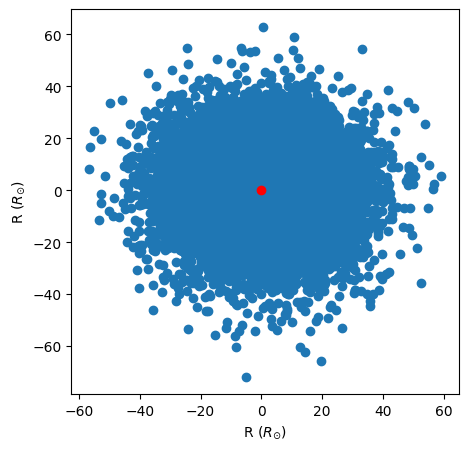

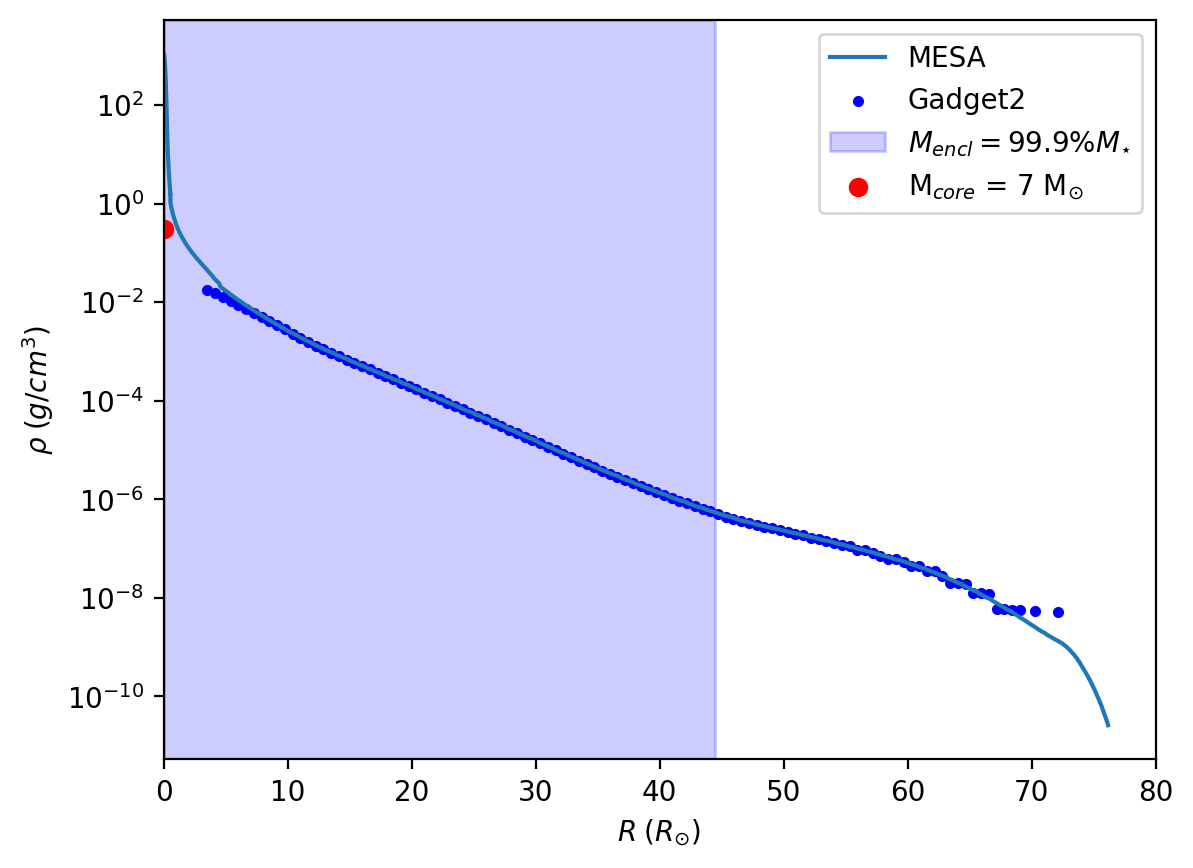

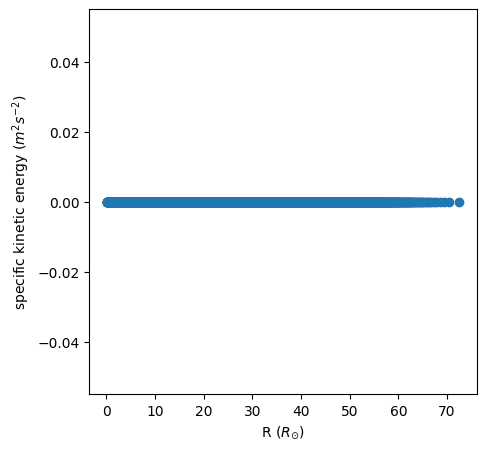

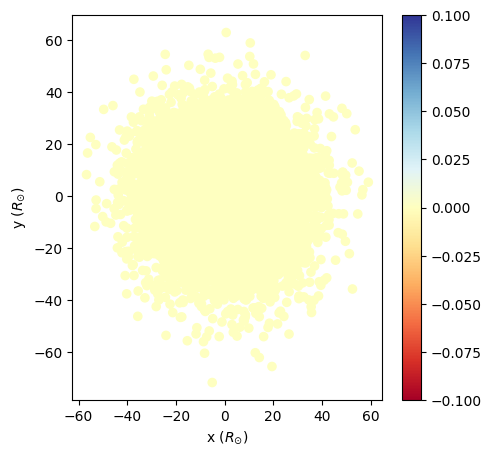

In [14]:
plot_giant(giant_model.gas_particles,giant_model.core_particle)
plt_dens_profiles(giant_rad_profile,giant_dens_profile,radii0,densities0,enc_mass_calc,0.0)
plot_spec_kin_energy(giant_model.gas_particles)
plot_spec_kin_energy_map(giant_model.gas_particles)

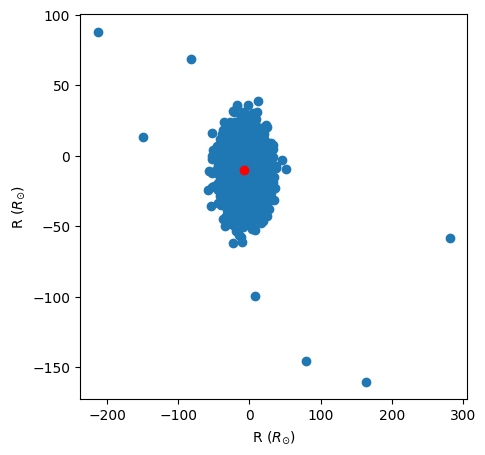

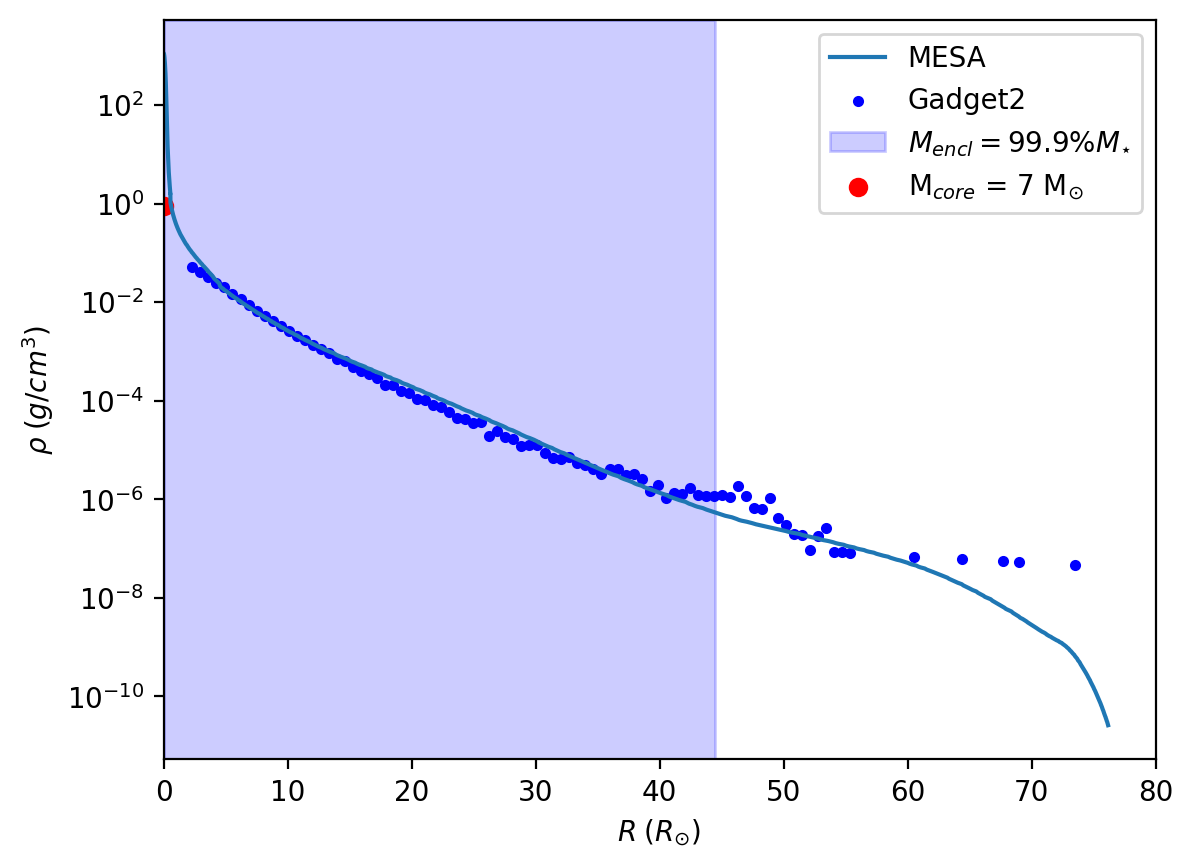

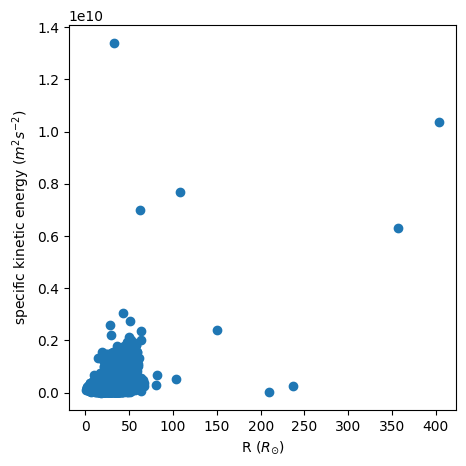

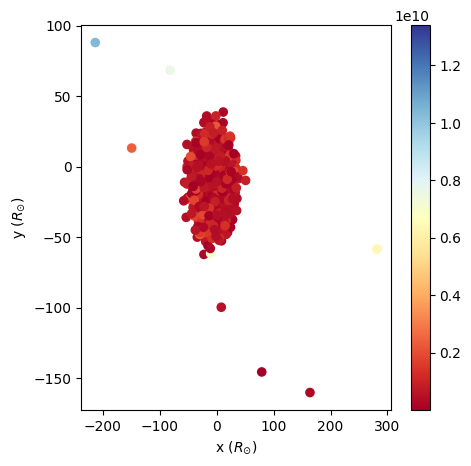

In [15]:
plot_giant(gas_particles1,core_particle1)
plt_dens_profiles(giant_rad_profile,giant_dens_profile,radii1,densities1,enc_mass_calc,1.0)
plot_spec_kin_energy(gas_particles1)
plot_spec_kin_energy_map(gas_particles1)

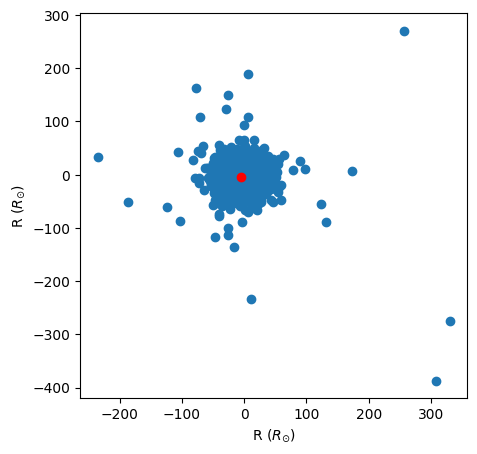

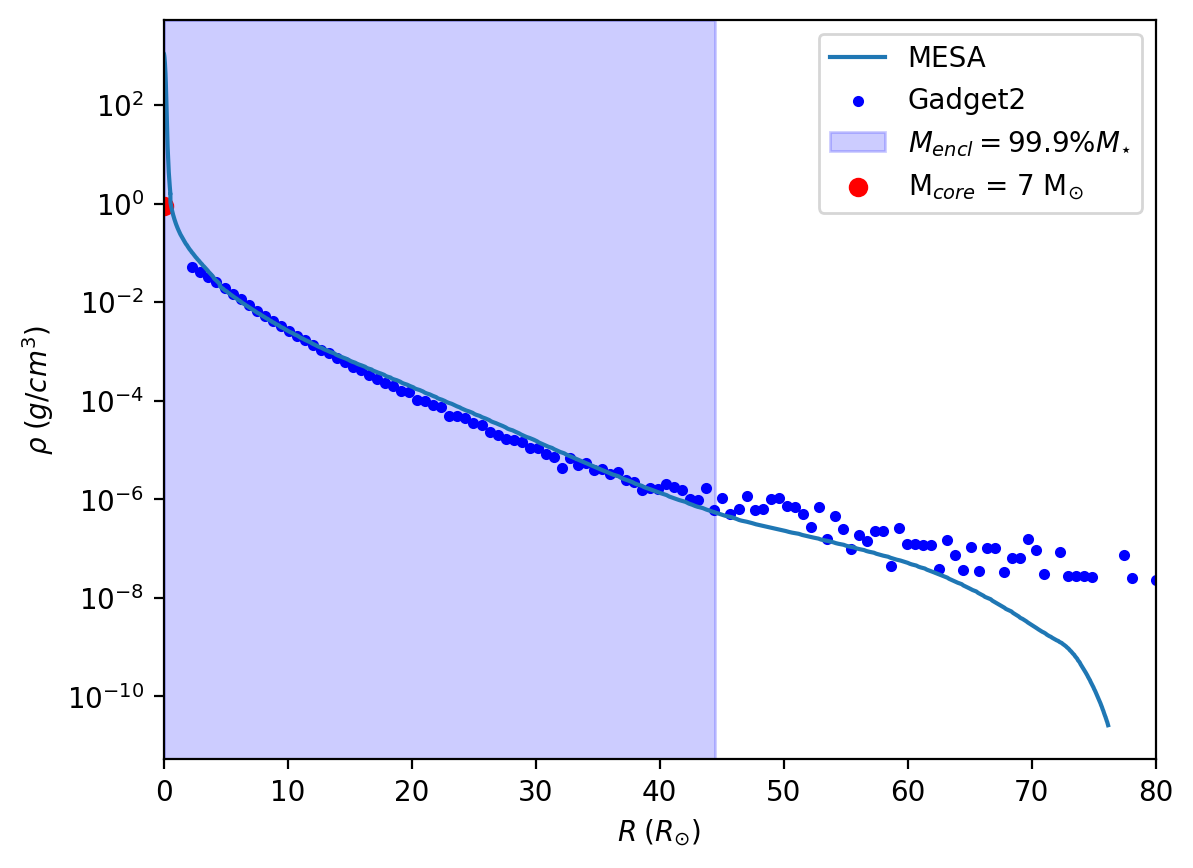

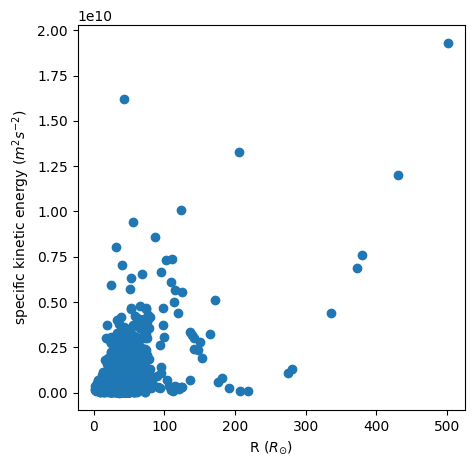

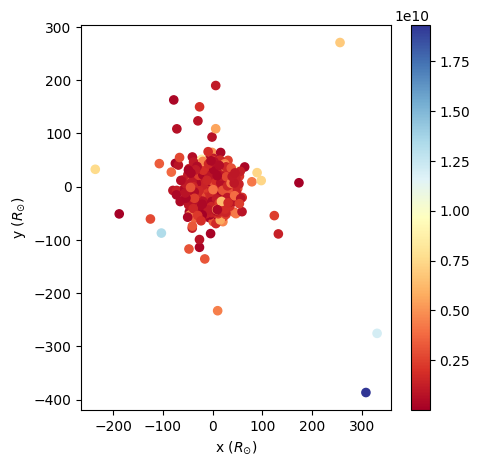

In [16]:
plot_giant(gas_particles2,core_particle2)
plt_dens_profiles(giant_rad_profile,giant_dens_profile,radii2,densities2,enc_mass_calc,1.0)
plot_spec_kin_energy(gas_particles2)
plot_spec_kin_energy_map(gas_particles2)

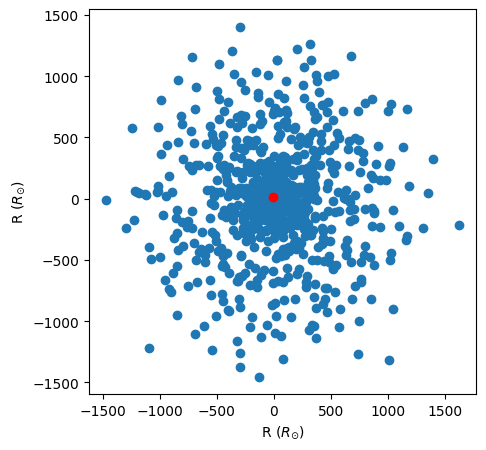

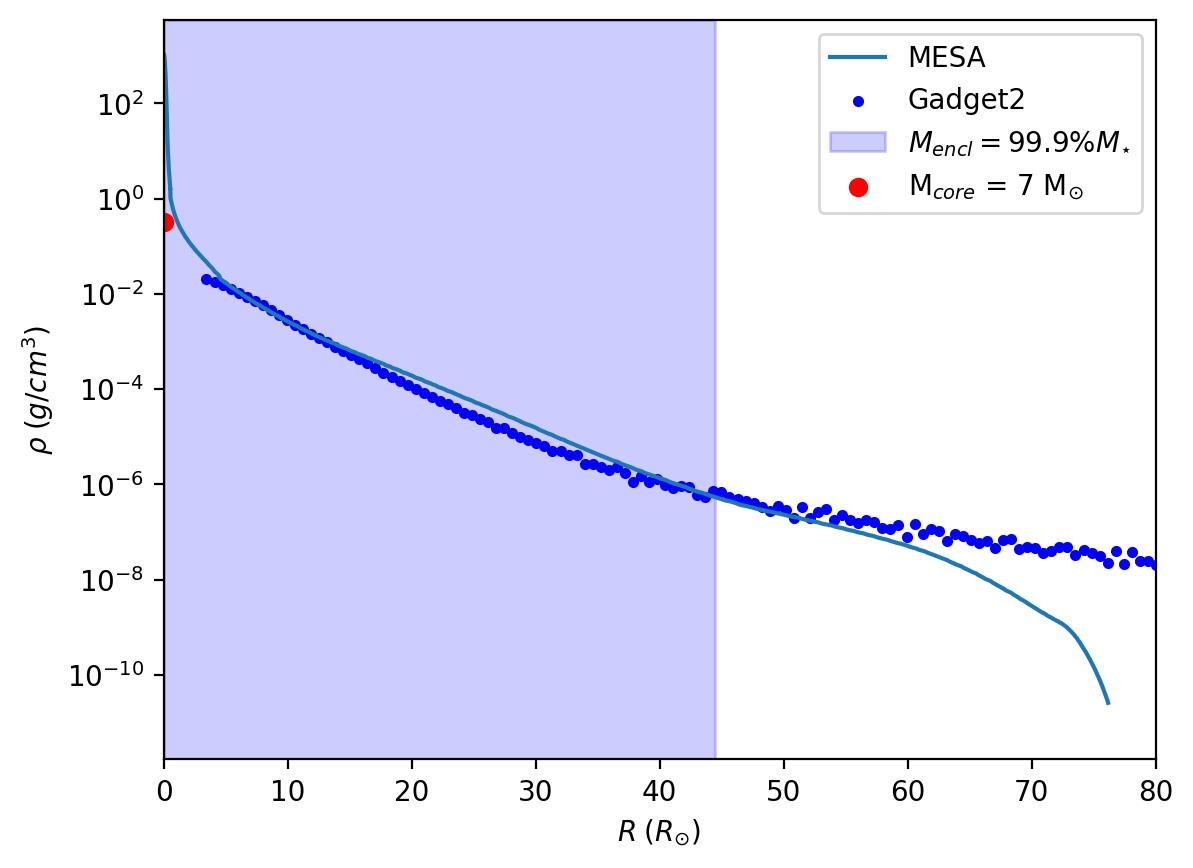

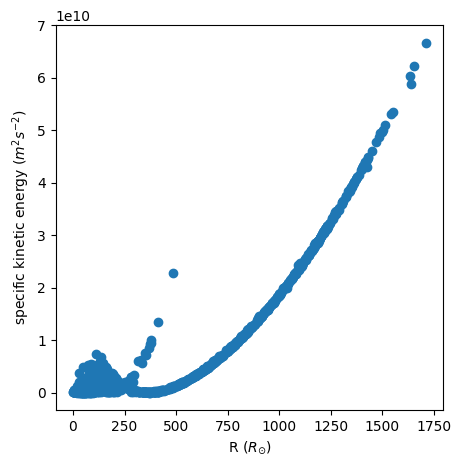

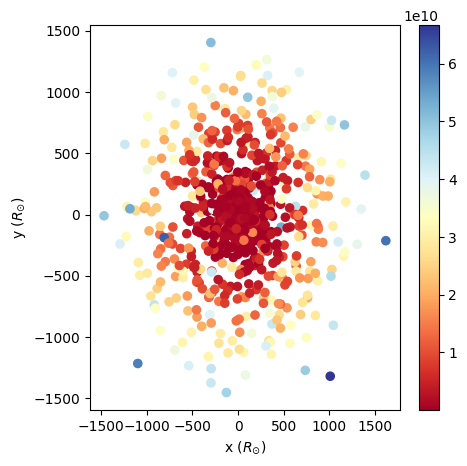

In [17]:
plot_giant(gas_particles3,core_particle3)
plt_dens_profiles(giant_rad_profile,giant_dens_profile,radii3,densities3,enc_mass_calc,3.0)
plot_spec_kin_energy(gas_particles3)
plot_spec_kin_energy_map(gas_particles3)

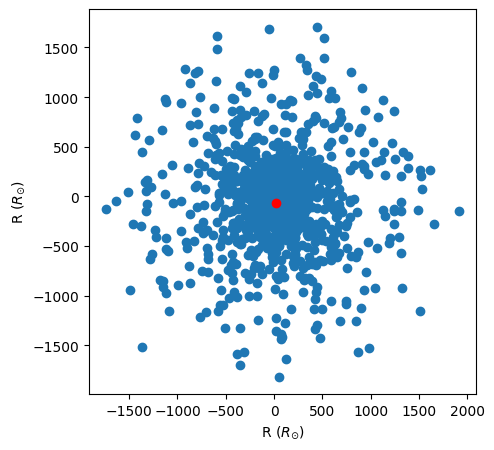

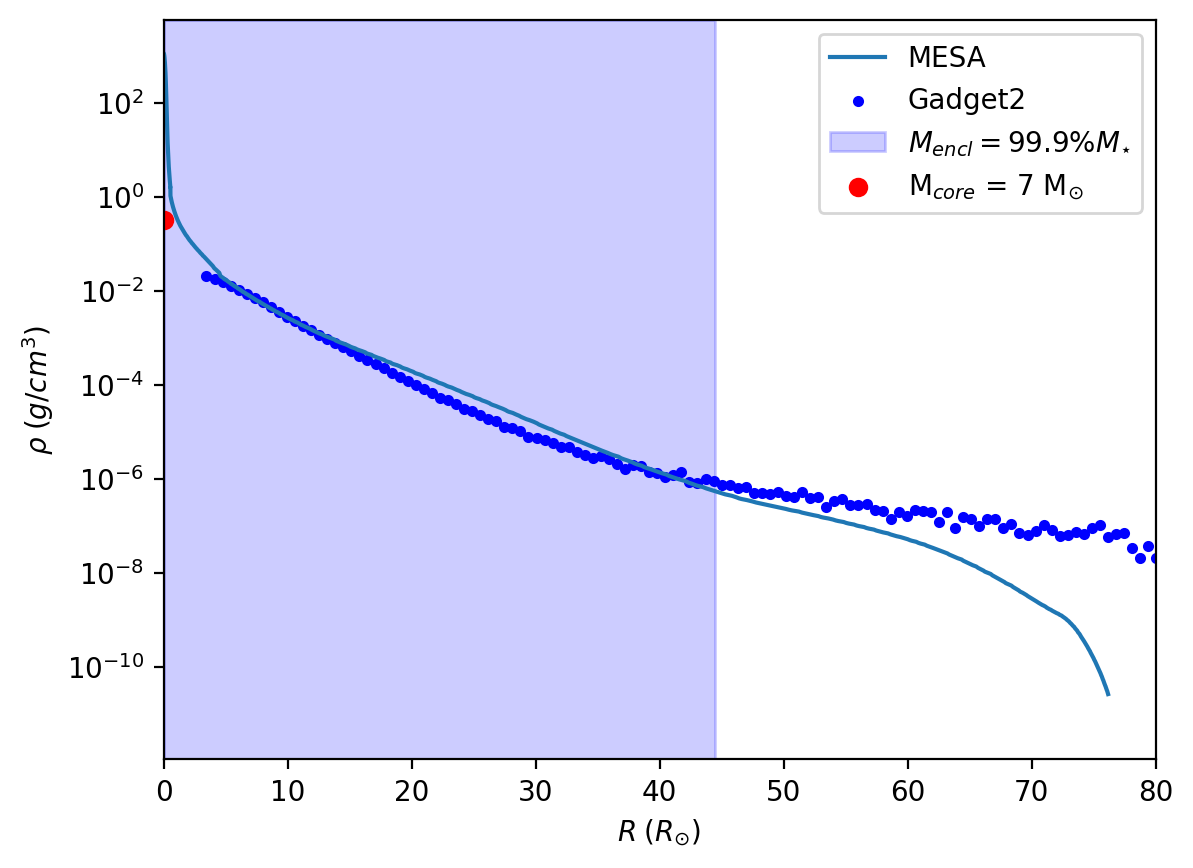

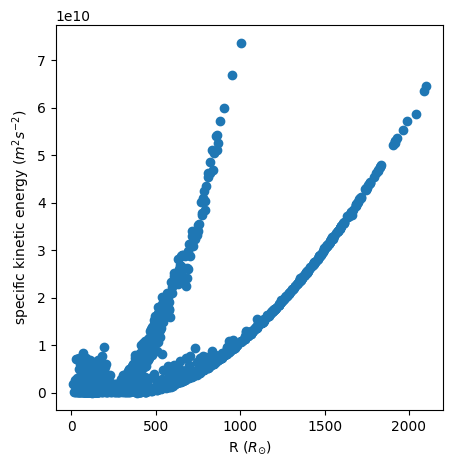

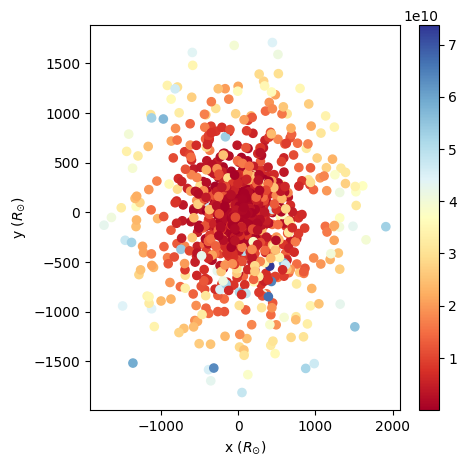

In [18]:
plot_giant(gas_particles4,core_particle4)
plt_dens_profiles(giant_rad_profile,giant_dens_profile,radii4,densities4,enc_mass_calc,1.0)
plot_spec_kin_energy(gas_particles4)
plot_spec_kin_energy_map(gas_particles4)